In [149]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,f1_score,
    precision_score,recall_score, 
    confusion_matrix, ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

In [150]:
product_data = pd.read_csv('../data/master_product_list.csv')
#make it so that the IDs match up for joins
product_data['prodSiteID'] = product_data['prodSiteID'].str.upper()

#read in all of our review data
review_data = pd.read_csv('../data/all_reviews_without_unicode.csv')
#make it so that the IDs match up for joins
review_data['prodSiteID'] = review_data['prodSiteID'].str.upper()

#merge some key variables from the products dataframe
#into the review dataframe for supporting model building and 
#analysis
review_data = review_data.merge(
    right=pd.DataFrame(
      product_data[
        [
            'product_price','prodSiteID',
            'prod_subjectivity','total_star_rating','site'
        ]
      ]
    ),
    on='prodSiteID',
    how='left'
)

#add a boolean/binary value for whether or not the review
#is "helpful" to other customers.
#we can also explore adjusting the setting for "helpful"
#in this binary based off of the distribution of the helpful votes
#e.g. if it has more than the median number of votes, it's helpful.

review_data['is_helpful'] = np.select(
    [
        review_data['review_helpful_votes'] > 0,
        review_data['review_helpful_votes'] == 0 | review_data['review_helpful_votes'].isna(),
    ],
    [
        1,
        0
    ]
)

C:\Users\khole\AppData\Local\Temp\ipykernel_7292\1897764794.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  review_data = pd.read_csv('../data/all_reviews_without_unicode.csv')


In [151]:
test_metrics = pd.DataFrame(
    {
        'Model':[],
        'Accuracy':[],
        'F1':[],
        'Precision':[],
        'Recall':[]
    }
)

In [152]:
review_data = pd.DataFrame(
    review_data[
        (review_data['productID'].isin([1,2,3,5,6,8,9,11,12,13,14,15])) &
        (review_data['review_lang']=='en')
    ]
)

In [156]:
oversample = RandomOverSampler(sampling_strategy='minority')

X,y = [review_data[
    ['review_star_rating','verified_purchase','review_subjectivity',
    'review_polarity', 'review_length','product_price', 'prod_subjectivity', 'total_star_rating']
],review_data['is_helpful']]


# Oversample the minority class

X_resampled, y_resampled = oversample.fit_resample(X, y)

scaler = StandardScaler()
X = scaler.fit_transform(X_resampled)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y_resampled, test_size=0.2, random_state=42)

,Model,Accuracy,F1,Precision,Recall
0,Logistic Regression,0.683461,0.645133,0.738557,0.572691
1,Logistic Regression,0.745912,0.722982,0.799324,0.659950


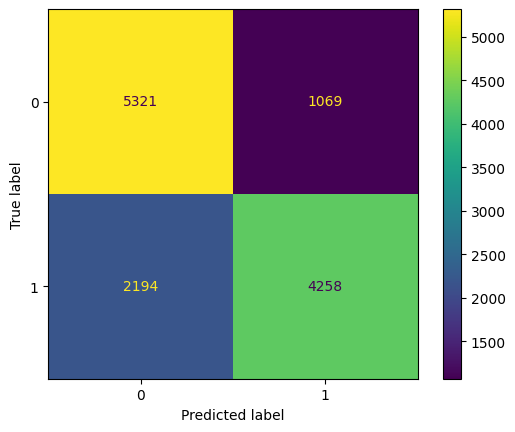

In [158]:
mod = LogisticRegression(penalty='l2')

log_reg = mod.fit(X_train,y_train)
#y_pred = (mod.predict_proba(X_test)[:,1] > .11)
mod.predict(X_test)
#y_pred = (mod.predict_proba(X_test)[:,1] > 0.5)
y_pred = mod.predict(X_test)
test_metrics.loc[len(test_metrics)] = {
    'Model':'Logistic Regression',
    'Accuracy':accuracy_score(y_test,y_pred),
    'F1':f1_score(y_test,y_pred),
    'Precision':precision_score(y_test,y_pred),
    'Recall':recall_score(y_test,y_pred)
}

ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

display(test_metrics)